TensorFlow and Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras



2025-12-02 00:09:42.563198: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from keras.preprocessing.image import load_img

In [4]:
path = 'clothing-dataset-small-master/train/t-shirt'
name = '5f0a3fa0-6a3d-4b68-b213-72766a643de7.jpg'
fullname = f'{path}/{name}'


In [5]:
img = load_img(fullname, target_size=(299, 299))

In [6]:
x = np.array(img)
x.shape

(299, 299, 3)

Pre-trained convolutional neural networks

In [7]:
from keras.applications.xception import Xception, preprocess_input, decode_predictions

In [8]:
model = Xception(weights='imagenet', input_shape=(299, 299, 3))

I0000 00:00:1764634185.933625  539728 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2071 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
X = np.array([x])
X.shape

(1, 299, 299, 3)

In [10]:
X = preprocess_input(X)

In [11]:
pred = model.predict(X)

2025-12-02 00:09:47.920142: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f5260006750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-02 00:09:47.920158: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-12-02 00:09:47.948272: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-02 00:09:48.276762: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600
2025-12-02 00:09:52.245067: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:09:52.367229: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel 

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


In [12]:
decode_predictions(pred)

[[('n03595614', 'jersey', np.float32(0.6821478)),
  ('n02916936', 'bulletproof_vest', np.float32(0.038052246)),
  ('n04370456', 'sweatshirt', np.float32(0.034298237)),
  ('n03710637', 'maillot', np.float32(0.011359435)),
  ('n04525038', 'velvet', np.float32(0.0018457148))]]

Transfer learning

Read the images

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
# Build image generator for training (takes preprocessing input function)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load in train dataset into train generator
train_ds = train_gen.flow_from_directory(directory='clothing-dataset-small-master/train', # Train images directory
                                         target_size=(150,150), # resize images to train faster
                                         batch_size=32) # 32 images per batch

# Create image generator for validation
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load in image for validation
val_ds = val_gen.flow_from_directory(directory='clothing-dataset-small-master/validation', # Validation image directory
                                     target_size=(150,150),
                                     batch_size=32,
                                     shuffle=False) # False for validation

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [15]:
X, y = next(train_ds)

In [16]:
X.shape

(32, 150, 150, 3)

In [17]:
train_ds.class_indices

{'dress': 0,
 'hat': 1,
 'longsleeve': 2,
 'outwear': 3,
 'pants': 4,
 'shirt': 5,
 'shoes': 6,
 'shorts': 7,
 'skirt': 8,
 't-shirt': 9}

Train a model

In [18]:
base_model = Xception(   # This will be our convulational layers
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3)
)
base_model.trainable = False # Freeze convolutional layers and remove dense layers

Create new top

In [19]:
# Build base model
base_model = Xception(weights='imagenet',
                      include_top=False, # to create custom dense layer
                      input_shape=(150,150,3))

# Freeze the convolutional base by preventing the weights being updated during training
base_model.trainable = False

# Define expected image shape as input
inputs = keras.Input(shape=(150,150,3))

# Feed inputs to the base model
base = base_model(inputs, training=False) # set False because the model contains BatchNormalization layer

# Convert matrices into vectors using pooling layer
vectors = keras.layers.GlobalAveragePooling2D()(base)

# Create dense layer of 10 classes
outputs = keras.layers.Dense(10)(vectors)

# Create model for training
model = keras.Model(inputs, outputs)

In [20]:
# Define learning rate
learning_rate = 0.01

# Create optimizer
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Define loss function
loss = keras.losses.CategoricalCrossentropy(from_logits=True) # to keep the raw output of dense layer without applying softmax

# Compile the model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy']) # evaluation metric accuracy

In [21]:
# Train the model, validate it with validation data, and save the training history
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10


2025-12-02 00:10:11.299065: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:11.439086: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:12.588341: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:12.708810: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:13.830072: E external/local_xla/xla/stream_

81/96 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5496 - loss: 1.9030

2025-12-02 00:10:29.611403: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:29.748629: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:30.774066: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:30.891808: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:31.898466: E external/local_xla/xla/stream_

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.5661 - loss: 1.8151

2025-12-02 00:10:45.320769: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:45.448102: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:46.342967: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:46.457448: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-02 00:10:47.395728: E external/local_xla/xla/stream_

96/96 ━━━━━━━━━━━━━━━━━━━━ 49s 340ms/step - accuracy: 0.6613 - loss: 1.3059 - val_accuracy: 0.7654 - val_loss: 0.8393
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8279 - loss: 0.5302 - val_accuracy: 0.8182 - val_loss: 0.7416
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8758 - loss: 0.3633 - val_accuracy: 0.7830 - val_loss: 0.9179
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.8993 - loss: 0.2918 - val_accuracy: 0.7918 - val_loss: 0.8827
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9257 - loss: 0.2092 - val_accuracy: 0.7889 - val_loss: 0.9000
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9563 - loss: 0.1267 - val_accuracy: 0.8182 - val_loss: 0.8672
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9795 - loss: 0.0719 - val_accuracy: 0.8152 - val_loss: 0.8823
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.9837 - loss: 0.0562 - val_accuracy: 0.8006 - val_loss: 

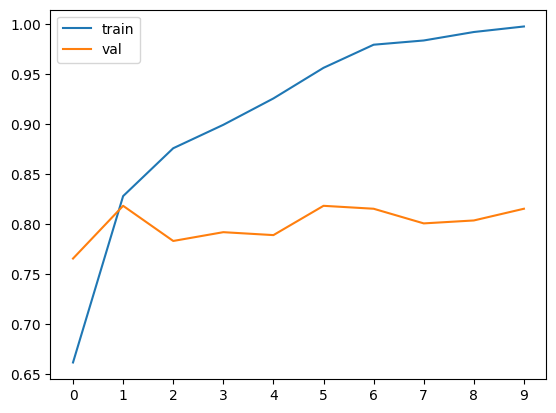

In [22]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

Adjusting the learning rate

In [23]:
# Function to create model
def make_model(learning_rate=0.01):
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(150,150,3))

    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(10)(vectors)
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

In [24]:
# Dictionary to store history with different learning rates
scores = {}

# List of learning rates
lrs = [0.0001, 0.001, 0.01, 0.1]

for lr in lrs:
    print(lr)
    
    model = make_model(learning_rate=lr)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[lr] = history.history
    
    print()
    print()

0.0001
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 19s 147ms/step - accuracy: 0.3579 - loss: 1.9369 - val_accuracy: 0.4897 - val_loss: 1.6169
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.5577 - loss: 1.3922 - val_accuracy: 0.5982 - val_loss: 1.2676
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.6372 - loss: 1.1513 - val_accuracy: 0.6510 - val_loss: 1.0904
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.6819 - loss: 1.0123 - val_accuracy: 0.6774 - val_loss: 0.9779
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - accuracy: 0.7063 - loss: 0.9175 - val_accuracy: 0.6921 - val_loss: 0.9080
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.7304 - loss: 0.8500 - val_accuracy: 0.7185 - val_loss: 0.8553
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.7370 - loss: 0.7963 - val_accuracy: 0.7361 - val_loss: 0.8121
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.7559 - loss: 0.7527 - val_accuracy: 0

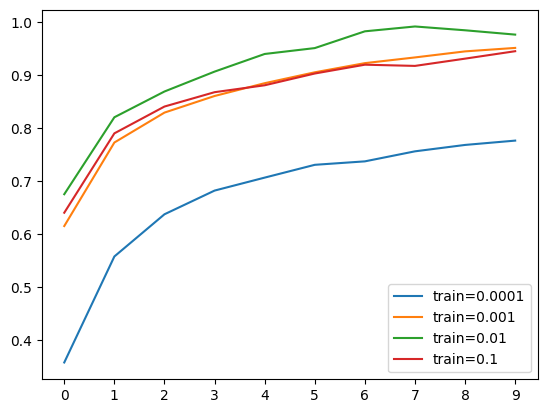

In [25]:
for lr, history in scores.items():
    # if lr == 0.0001 or lr == 0.1:
    #     continue
    plt.plot(history['accuracy'], label=f'train={lr}')
    # plt.plot(history['val_accuracy'], label=f'val={lr}')
plt.xticks(np.arange(10))
plt.legend()

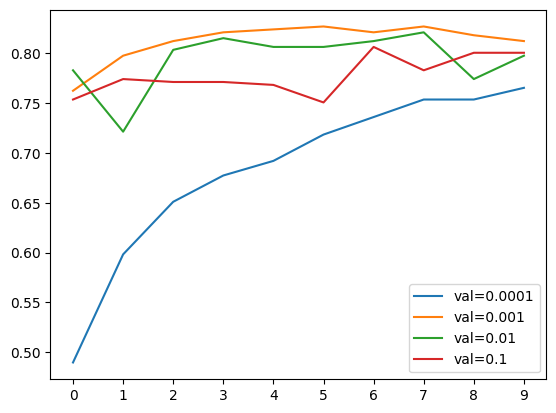

In [26]:
for lr, history in scores.items():
    # if lr == 0.0001 or lr == 0.1:
    #     continue
    # plt.plot(history['accuracy'], label=f'train={lr}')
    plt.plot(history['val_accuracy'], label=f'val={lr}')
plt.xticks(np.arange(10))
plt.legend()

In [27]:
learning_rate = 0.001

Checkpoints

In [28]:
model.save_weights(filepath='model_v1.weights.h5')

In [29]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [30]:
learning_rate = 0.001
 
model = make_model(learning_rate=learning_rate)
 
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5198 - loss: 1.4561

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.6323 - loss: 1.0971 - val_accuracy: 0.7859 - val_loss: 0.6878
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7611 - loss: 0.6865

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7875 - loss: 0.6288 - val_accuracy: 0.8065 - val_loss: 0.5980
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8415 - loss: 0.5030

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8341 - loss: 0.5084 - val_accuracy: 0.8299 - val_loss: 0.5599
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.8631 - loss: 0.4281

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8582 - loss: 0.4352 - val_accuracy: 0.8358 - val_loss: 0.5396
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8778 - loss: 0.3791 - val_accuracy: 0.8182 - val_loss: 0.5462
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9038 - loss: 0.3252 - val_accuracy: 0.8240 - val_loss: 0.5537
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9336 - loss: 0.2703

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9234 - loss: 0.2876 - val_accuracy: 0.8387 - val_loss: 0.5146
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9332 - loss: 0.2566 - val_accuracy: 0.8182 - val_loss: 0.5203
Epoch 9/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9407 - loss: 0.2324 - val_accuracy: 0.8182 - val_loss: 0.5162
Epoch 10/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9472 - loss: 0.2138 - val_accuracy: 0.8240 - val_loss: 0.5295


Inner layer

In [31]:
# Function to define model by adding new dense layer
def make_model(learning_rate=0.01, size_inner=100): # default layer size is 100
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(150,150,3))

    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors) # activation function 'relu'
    outputs = keras.layers.Dense(10)(inner)
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model

In [32]:
# Experiement different number of inner layer with best learning rate
# Note: We should've added the checkpoint for training but for simplicity we are skipping it
learning_rate = 0.001

scores = {}

# List of inner layer sizes
sizes = [10, 100, 1000]

for size in sizes:
    print(size)
    
    model = make_model(learning_rate=learning_rate, size_inner=size)
    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[size] = history.history
    
    print()
    print()

10
Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.3553 - loss: 1.6949 - val_accuracy: 0.5484 - val_loss: 1.3080
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.6532 - loss: 1.0622 - val_accuracy: 0.7009 - val_loss: 0.9535
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.7405 - loss: 0.8158 - val_accuracy: 0.7713 - val_loss: 0.8025
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7709 - loss: 0.7021 - val_accuracy: 0.7713 - val_loss: 0.7238
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.7943 - loss: 0.6227 - val_accuracy: 0.7683 - val_loss: 0.7020
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8198 - loss: 0.5516 - val_accuracy: 0.7595 - val_loss: 0.6886
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8422 - loss: 0.4967 - val_accuracy: 0.7830 - val_loss: 0.6567
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.8602 - loss: 0.4491 - val_accuracy: 0.783

2025-12-02 00:19:49.627359: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 00:19:50.427210: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 24 bytes spill stores, 24 bytes spill loads

2025-12-02 00:19:50.889498: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4237', 68 bytes spill stores, 68 bytes spill loads



12/96 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.3079 - loss: 2.0746

2025-12-02 00:19:55.556208: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 56 bytes spill stores, 56 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5458 - loss: 1.3642

2025-12-02 00:20:07.362787: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1086', 56 bytes spill stores, 56 bytes spill loads



96/96 ━━━━━━━━━━━━━━━━━━━━ 23s 166ms/step - accuracy: 0.6571 - loss: 1.0114 - val_accuracy: 0.7713 - val_loss: 0.6714
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8110 - loss: 0.5318 - val_accuracy: 0.7801 - val_loss: 0.6359
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.8703 - loss: 0.3851 - val_accuracy: 0.8006 - val_loss: 0.5821
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.9120 - loss: 0.2693 - val_accuracy: 0.8094 - val_loss: 0.5749
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9508 - loss: 0.1824 - val_accuracy: 0.7947 - val_loss: 0.6030
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9703 - loss: 0.1274 - val_accuracy: 0.8328 - val_loss: 0.5738
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9827 - loss: 0.0954 - val_accuracy: 0.8123 - val_loss: 0.6068
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9935 - loss: 0.0647 - val_accuracy: 0.8182 - val_loss: 

2025-12-02 00:21:13.048862: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-02 00:21:13.497940: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 00:21:13.794528: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 24 bytes spill stores, 24 bytes spill loads

2025-12-02 00:21:15.053352: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4237', 68 byte

24/96 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.4568 - loss: 1.7827

2025-12-02 00:21:19.856504: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 00:21:20.673211: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3800', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 00:21:20.783857: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3800', 32 bytes spill stores, 32 bytes spill loads

2025-12-02 00:21:20.802983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3793', 56 bytes spill stores, 56 bytes spill loads

2025-12-02 00:21:20.922651: I external/local

96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6000 - loss: 1.2578

2025-12-02 00:21:32.365167: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1086', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 00:21:32.629386: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1093', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 00:21:33.060593: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1086', 56 bytes spill stores, 56 bytes spill loads

2025-12-02 00:21:33.233480: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1093', 32 bytes spill stores, 32 bytes spill loads

2025-12-02 00:21:33.372271: I external/local

96/96 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - accuracy: 0.6858 - loss: 0.9399 - val_accuracy: 0.7742 - val_loss: 0.6483
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8468 - loss: 0.4393 - val_accuracy: 0.8123 - val_loss: 0.5920
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9065 - loss: 0.2665 - val_accuracy: 0.8006 - val_loss: 0.6337
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9514 - loss: 0.1587 - val_accuracy: 0.8123 - val_loss: 0.6205
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9746 - loss: 0.0906 - val_accuracy: 0.8094 - val_loss: 0.6758
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9863 - loss: 0.0577 - val_accuracy: 0.8240 - val_loss: 0.6058
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9967 - loss: 0.0303 - val_accuracy: 0.8270 - val_loss: 0.6581
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9990 - loss: 0.0125 - val_accuracy: 0.8240 - val_loss: 

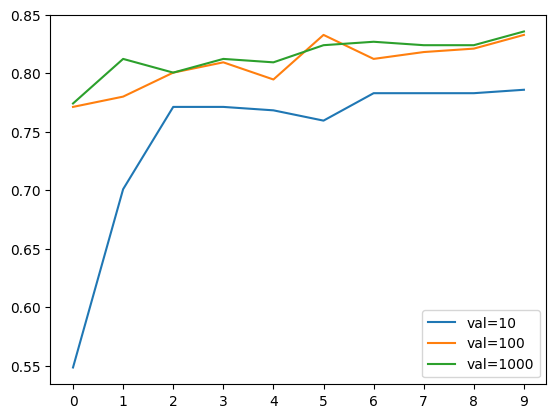

In [33]:
for size, history in scores.items():
    # if lr == 0.0001 or lr == 0.1:
    #     continue
    plt.plot(history['val_accuracy'], label=f'val={size}')
plt.xticks(np.arange(10))
plt.legend()

Dropout & Regularization

In [34]:
# Function to define model by adding new dense layer and dropout
def make_model(learning_rate=0.01, size_inner=100, droprate=0.5):
    base_model = Xception(weights='imagenet',
                          include_top=False,
                          input_shape=(150,150,3))

    base_model.trainable = False
    
    #########################################
    
    inputs = keras.Input(shape=(150,150,3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner) # add dropout layer
    outputs = keras.layers.Dense(10)(drop)
    model = keras.Model(inputs, outputs)
    
    #########################################
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['accuracy'])
    
    return model


# Create checkpoint to save best model for version 3
filepath = './xception_v3_{epoch:02d}_{val_accuracy:.3f}.h5'
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                                             save_best_only=True,
                                             monitor='val_accuracy',
                                             mode='max')

# Set the best values of learning rate and inner layer size based on previous experiments
learning_rate = 0.001
size = 100

# Dict to store results
scores = {}

# List of dropout rates
droprates = [0.0, 0.2, 0.5, 0.8]

for droprate in droprates:
    print(droprate)
    
    model = make_model(learning_rate=learning_rate,
                       size_inner=size,
                       droprate=droprate)
    
    # Train for longer (epochs=30) cause of dropout regularization
    history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=[checkpoint])
    scores[droprate] = history.history
    
    print()
    print()

0.0
Epoch 1/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5678 - loss: 1.2732

96/96 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.6724 - loss: 0.9673 - val_accuracy: 0.7742 - val_loss: 0.6904
Epoch 2/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8195 - loss: 0.5251

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.8266 - loss: 0.5018 - val_accuracy: 0.8094 - val_loss: 0.5853
Epoch 3/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.8833 - loss: 0.3424 - val_accuracy: 0.7947 - val_loss: 0.6034
Epoch 4/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9288 - loss: 0.2482

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - accuracy: 0.9276 - loss: 0.2507 - val_accuracy: 0.8328 - val_loss: 0.5584
Epoch 5/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9544 - loss: 0.1681 - val_accuracy: 0.8211 - val_loss: 0.5639
Epoch 6/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9622 - loss: 0.1394 - val_accuracy: 0.8299 - val_loss: 0.5634
Epoch 7/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9873 - loss: 0.0835 - val_accuracy: 0.8270 - val_loss: 0.6310
Epoch 8/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9945 - loss: 0.0572 - val_accuracy: 0.8211 - val_loss: 0.5844
Epoch 9/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9967 - loss: 0.0436 - val_accuracy: 0.8123 - val_loss: 0.6411
Epoch 10/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9987 - loss: 0.0304 - val_accuracy: 0.7977 - val_loss: 0.6847
Epoch 11/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9997 - loss: 0.0218 - val_accuracy: 0.8211 - val_loss: 

96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9925 - loss: 0.0347 - val_accuracy: 0.8416 - val_loss: 0.6341
Epoch 18/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9938 - loss: 0.0310 - val_accuracy: 0.8270 - val_loss: 0.6837
Epoch 19/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9938 - loss: 0.0285 - val_accuracy: 0.8240 - val_loss: 0.6985
Epoch 20/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9954 - loss: 0.0263 - val_accuracy: 0.8240 - val_loss: 0.7201
Epoch 21/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9948 - loss: 0.0280 - val_accuracy: 0.8152 - val_loss: 0.7006
Epoch 22/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9941 - loss: 0.0288 - val_accuracy: 0.8065 - val_loss: 0.7498
Epoch 23/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9958 - loss: 0.0261 - val_accuracy: 0.8182 - val_loss: 0.7383
Epoch 24/30
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9974 - loss: 0.0177 - val_accuracy: 0.8182 - val_l

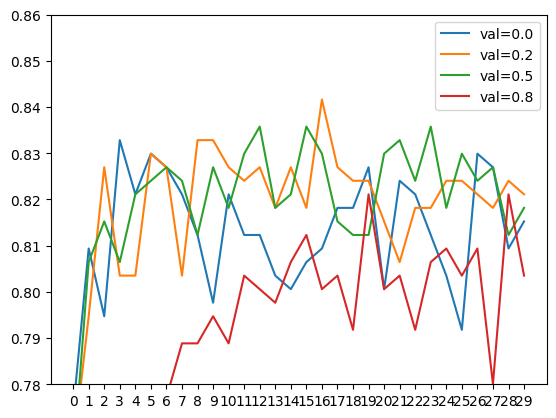

In [35]:
for rate, history in scores.items():
    plt.plot(history['val_accuracy'], label=f'val={rate}')
plt.xticks(np.arange(30))
plt.ylim(0.78, 0.86)
plt.legend()

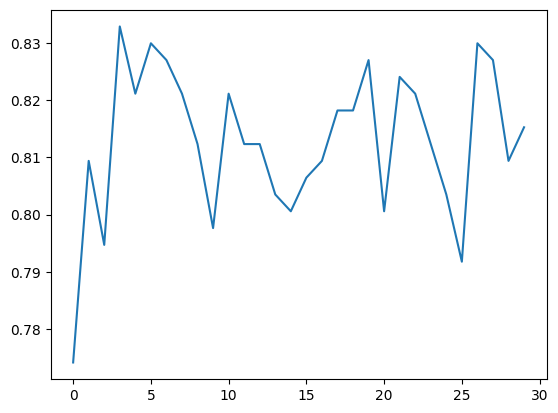

In [36]:
rate = 0.0
hist = scores[rate]
plt.plot(hist['val_accuracy'], label=f'val={rate}')
# plt.plot(hist['accuracy'], label=f'train={rate}')

Data augmentation

In [37]:
# Build image generator for training (takes preprocessing input function)
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input, 
                            #    rotation_range=30,
                            #    width_shift_range=10.0,
                            #    height_shift_range=10.0,
                               shear_range=10,
                               zoom_range=0.1,
                               vertical_flip=True)

# Load in train dataset into train generator
train_ds = train_gen.flow_from_directory(directory='clothing-dataset-small-master/train', # Train images directory
                                         target_size=(150,150), # resize images to train faster
                                         batch_size=32) # 32 images per batch

# Create image generator for validation
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Load in image for validation
val_ds = val_gen.flow_from_directory(directory='clothing-dataset-small-master/validation', # Validation image directory
                                     target_size=(150,150),
                                     batch_size=32,
                                     shuffle=False) # False for validation

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [38]:
# Set the best values of learning rate and inner layer size based on previous experiments
learning_rate = 0.001
size = 100
droprate = 0.2

model = make_model(learning_rate=learning_rate,
                    size_inner=size,
                    droprate=droprate)

# Train for longer (epochs=30) cause of dropout regularization
history = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.5727 - loss: 1.2820 - val_accuracy: 0.7478 - val_loss: 0.7806
Epoch 2/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.6956 - loss: 0.9053 - val_accuracy: 0.7595 - val_loss: 0.7207
Epoch 3/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.7301 - loss: 0.7894 - val_accuracy: 0.7859 - val_loss: 0.6696
Epoch 4/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - accuracy: 0.7542 - loss: 0.7337 - val_accuracy: 0.7830 - val_loss: 0.6414
Epoch 5/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.7764 - loss: 0.6706 - val_accuracy: 0.8006 - val_loss: 0.6009
Epoch 6/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.7885 - loss: 0.6111 - val_accuracy: 0.7947 - val_loss: 0.6094
Epoch 7/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.8041 - loss: 0.5691 - val_accuracy: 0.8211 - val_loss: 0.5933
Epoch 8/50
96/96 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.8191 - loss: 0.5475 - val_accu

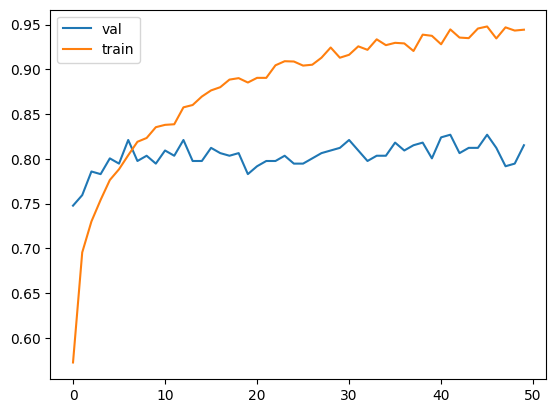

In [39]:
hist = history.history
plt.plot(hist['val_accuracy'], label='val')
plt.plot(hist['accuracy'], label='train')
 
plt.legend()

Training a larger model

In [40]:
def make_model(input_size=150, learning_rate=0.01, size_inner=100,
               droprate=0.5):
 
    base_model = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=(input_size, input_size, 3)
    )
 
    base_model.trainable = False
 
    #########################################
 
    inputs = keras.Input(shape=(input_size, input_size, 3))
    base = base_model(inputs, training=False)
    vectors = keras.layers.GlobalAveragePooling2D()(base)
     
    inner = keras.layers.Dense(size_inner, activation='relu')(vectors)
    drop = keras.layers.Dropout(droprate)(inner)
     
    outputs = keras.layers.Dense(10)(drop)
     
    model = keras.Model(inputs, outputs)
     
    #########################################
 
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
 
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
     
    return model

In [41]:
input_size = 299

In [42]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)
 
train_ds = train_gen.flow_from_directory(
    'clothing-dataset-small-master/train',
    target_size=(input_size, input_size),
    batch_size=32
)
 
 
val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
val_ds = train_gen.flow_from_directory(
    'clothing-dataset-small-master/validation',
    target_size=(input_size, input_size),
    batch_size=32,
    shuffle=False
)

Found 3068 images belonging to 10 classes.
Found 341 images belonging to 10 classes.


In [43]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v4_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [47]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

tf.config.optimizer.set_jit(False)

In [48]:
learning_rate = 0.001
size = 100
droprate = 0.2
 
model = make_model(
    input_size=input_size,
    learning_rate=learning_rate,
    size_inner=size,
    droprate=droprate
)
 
history = model.fit(train_ds, epochs=50, validation_data=val_ds,
                   callbacks=[checkpoint])

Epoch 1/50


2025-12-02 00:56:43.161835: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-02 00:56:43.161879: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-02 00:56:43.161894: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-12-02 00:56:43.161909: W external/local_xla/xla

UnknownError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/kernelapp.py", line 758, in start

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/tornado/platform/asyncio.py", line 211, in start

  File "/var/home/alexis/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/asyncio/base_events.py", line 683, in run_forever

  File "/var/home/alexis/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/asyncio/base_events.py", line 2050, in _run_once

  File "/var/home/alexis/.local/share/uv/python/cpython-3.13.9-linux-x86_64-gnu/lib/python3.13/asyncio/events.py", line 89, in _run

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 614, in shell_main

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_shell

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 366, in execute_request

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/kernelbase.py", line 827, in execute_request

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 458, in do_execute

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/ipykernel/zmqshell.py", line 663, in run_cell

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3116, in run_cell

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3171, in _run_cell

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3394, in run_cell_async

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3639, in run_ast_nodes

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/IPython/core/interactiveshell.py", line 3699, in run_code

  File "/tmp/ipykernel_539728/1631840004.py", line 12, in <module>

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 399, in fit

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 241, in function

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in multi_step_on_iterator

  File "/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/keras/src/backend/tensorflow/trainer.py", line 125, in wrapper

Failed to determine best cudnn convolution algorithm for:
%cudnn-conv.79 = (f16[32,147,147,128]{3,2,1,0}, u8[0]{0}) custom-call(%maximum.1041, %bitcast.70), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, feature_group_count=128, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="functional_16_1/xception_1/block2_sepconv2_1/separable_conv2d/depthwise" source_file="/var/home/alexis/src/machine-learning-zoomcamp-ml_models-homeworks/.venv/lib/python3.13/site-packages/tensorflow/python/framework/ops.py" source_line=1221}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}

Original error: INTERNAL: All algorithms tried for (f16[32,147,147,128]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,147,147,128]{3,2,1,0}, f16[128,3,3,1]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, feature_group_count=128, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","reification_cost":[],"wait_on_operation_queues":[]} failed. Falling back to default algorithm.  Per-algorithm errors:
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16779664 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777856 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1432981520 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1432981520 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1432981520 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 178398848 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 43396352 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 194844800 bytes. [tf-allocator-allocation-error='']
  Scratch allocation failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 193807488 bytes. [tf-allocator-allocation-error='']

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_290930]

Using the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.xception import preprocess_input

In [ ]:
# Loading the model
model = keras.models.load_model('xception_v1_09_0.839.h5')

In [ ]:
# Load the test dataset
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
test_ds = test_gen.flow_from_directory(
    'clothing-dataset-small-master/validation',
    target_size=(299, 299),
    batch_size=32,
    shuffle=False
)

In [ ]:
model.evaluate(test_ds)

Getting predictions

In [ ]:
import numpy as np
 
path = 'clothing-dataset-small/test/pants/c8d21106-bbdb-4e8d-83e4-bf3d14e54c16.jpg'
 
img = load_img(path, target_size=(299, 299))
 
x = np.array(img)
X = np.array([x])
X.shape
 
# Output: (1, 299, 299, 3)
 
X = preprocess_input(X)
pred = model.predict(X)

In [ ]:
classes = [
    'dress',
    'hat',
    'longsleeve',
    'outwear',
    'pants',
    'shirt',
    'shoes',
    'shorts',
    'skirt',
    't-shirt'
]
 
dict(zip(classes, pred[0]))